In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import datetime as dt

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [3]:
model_names = [

    "rpo_ls_small_sample_mle_mle_cs2006",

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [4]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [5]:
all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
rpo_ls_small_sample_mle_mle_cs2006,1.100626,2.529482,0.435119,0.608464,-0.834343,-2.99772,0.502804


## 2) Cummulative Returns of the Portfolios

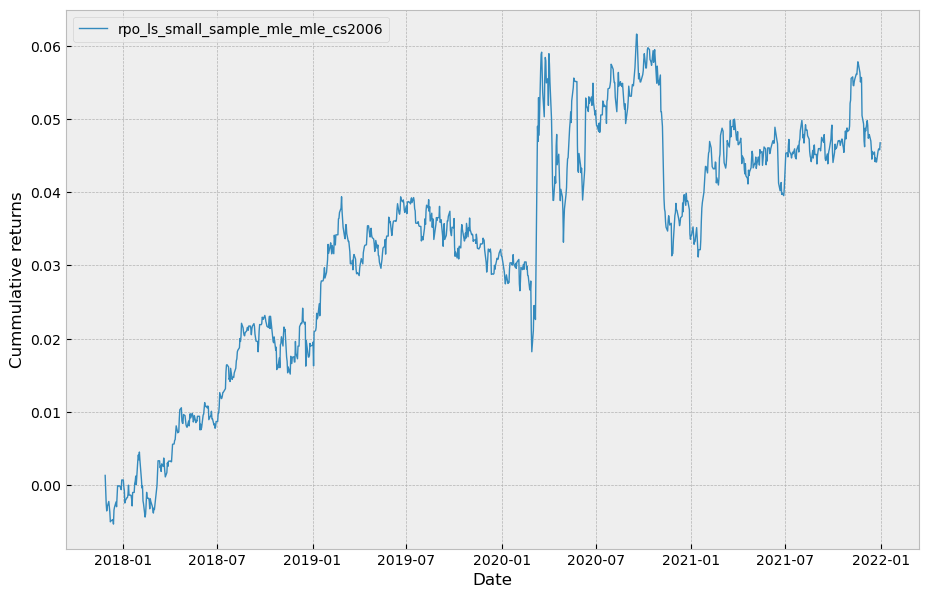

In [6]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2014-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [8]:
check_name = model_names[0]
all_summary_df.loc[(all_summary_df["model"] == check_name), ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,148730.000000,1.487300e+05,1.487300e+05
mean,0.000591,-1.510946e-12,3.142132e-07
std,0.026220,1.149976e-02,1.357299e-04
min,-0.680769,-1.021607e-01,-9.456927e-03
25%,-0.008045,-4.634401e-03,-3.996174e-05
50%,0.000000,-3.324779e-04,-0.000000e+00
75%,0.009249,5.020205e-03,4.075560e-05
max,0.939655,9.679190e-02,4.363141e-03


## 4) Check volatility

In [ ]:
rpo_vols = [26.9396, 26.9211,  8.9954, 18.5788, 49.8493, 35.6553, 20.6908, 95.9191,
            24.1774, 15.8174, 15.5722, 26.4226, 20.5379, 30.8954, 19.9433, 98.9528,
            20.0193, 21.0762, 32.0181, 19.8229, 19.7902, 29.8635, 16.7544, 58.3446,
            24.5295, 48.3536, 60.1742, 29.9285, 21.9999, 56.4160, 20.8969, 14.8802,
            21.4455, 22.6810, 17.4085, 27.8823, 56.5473, 38.0376, 36.7161, 44.8483,
            23.2286, 13.7809, 13.6748,  9.9189, 18.2429, 60.5969, 22.7223, 19.6394,
            10.2324, 38.2764, 22.2719, 33.5956,  9.0833, 17.2367, 29.6936, 35.1154,
            27.1677, 26.8934, 23.2493, 47.7808, 22.7166, 24.4911, 19.4291, 13.5696,
            26.3082, 35.3520, 19.1293, 19.5094, 22.4935, 17.5054, 19.1010, 19.3302,
            17.4388, 44.8711, 31.6211, 38.0957, 26.2266, 27.7276, 23.5032, 37.8263,
            16.4612, 21.6220, 19.3778, 25.7832, 12.5878, 29.8693, 15.8800, 23.3000,
            17.0101, 11.1003, 27.2698, 19.6278,  9.8462, 14.4660, 12.9294, 20.1954,
            23.4991, 36.1450, 19.4255, 17.3621, 29.9410, 18.0450,  9.9867, 25.1183,
            41.6237, 23.9049, 35.9097, 31.8606, 43.8938, 19.3092,  6.6033, 58.7112,
            15.7506, 10.3728, 19.4270, 23.0975, 20.0206, 35.4625,  8.5684, 17.9572,
            21.2270, 21.3685, 23.6745, 24.4145, 24.7669, 26.7404, 16.7232, 35.9204,
            21.8720, 23.6985, 29.5155, 18.1720, 29.2315, 18.8410, 21.2368,  7.7150,
            10.1547, 23.5041, 38.4707]

In [ ]:
mvo_vols = [26.9396, 26.9211,  8.9954, 18.5788, 49.8493, 35.6553, 20.6908, 95.9191,
            24.1774, 15.8174, 15.5722, 26.4226, 20.5379, 30.8954, 19.9433, 98.9528,
            20.0193, 21.0762, 32.0181, 19.8229, 19.7902, 29.8635, 16.7544, 58.3446,
            24.5295, 48.3536, 60.1742, 29.9285, 21.9999, 56.4160, 20.8969, 14.8802,
            21.4455, 22.6810, 17.4085, 27.8823, 56.5473, 38.0376, 36.7161, 44.8483,
            23.2286, 13.7809, 13.6748,  9.9189, 18.2429, 60.5969, 22.7223, 19.6394,
            10.2324, 38.2764, 22.2719, 33.5956,  9.0833, 17.2367, 29.6936, 35.1154,
            27.1677, 26.8934, 23.2493, 47.7808, 22.7166, 24.4911, 19.4291, 13.5696,
            26.3082, 35.3520, 19.1293, 19.5094, 22.4935, 17.5054, 19.1010, 19.3302,
            17.4388, 44.8711, 31.6211, 38.0957, 26.2266, 27.7276, 23.5032, 37.8263,
            16.4612, 21.6220, 19.3778, 25.7832, 12.5878, 29.8693, 15.8800, 23.3000,
            17.0101, 11.1003, 27.2698, 19.6278,  9.8462, 14.4660, 12.9294, 20.1954,
            23.4991, 36.1450, 19.4255, 17.3621, 29.9410, 18.0450,  9.9867, 25.1183,
            41.6237, 23.9049, 35.9097, 31.8606, 43.8938, 19.3092,  6.6033, 58.7112,
            15.7506, 10.3728, 19.4270, 23.0975, 20.0206, 35.4625,  8.5684, 17.9572,
            21.2270, 21.3685, 23.6745, 24.4145, 24.7669, 26.7404, 16.7232, 35.9204,
            21.8720, 23.6985, 29.5155, 18.1720, 29.2315, 18.8410, 21.2368,  7.7150,
            10.1547, 23.5041, 38.4707]